# Mimicvat visual data
This notebook is for digging into the mimicvat data and visualizing interesting patterns. My plan is to eventually display this data on the website.

I set up my document here by importing typical libraries and connecting to the database file.

In [1]:
import pandas as pd
import sqlite3

conn = sqlite3.connect("CARDINFO.db")
query = "select * from CARDS"
df = pd.read_sql_query(query,conn)
df.head()

,ID,NAME,CMC,MANACOST,POWER,TOUGHNESS,COLOR,CARDSET,TYPE,PICURL,FOIL,NONFOIL,ONLINEONLY,RARITY
0,2ae1bb79-a931-4d2e-9cc9-a06862dc5cde,God-Eternal Bontu,5.0,{3}{B}{B},5,6,['B'],ps19,Legendary Creature — Zombie God,https://img.scryfall.com/cards/normal/front/2/...,True,False,False,mythic
1,4889a668-0f01-4447-ad2e-91b329258f22,God-Eternal Kefnet,4.0,{2}{U}{U},4,5,['U'],ps19,Legendary Creature — Zombie God,https://img.scryfall.com/cards/normal/front/4/...,True,False,False,mythic
2,5b13ba5a-f4b0-420a-9e4f-a65e57721fa4,God-Eternal Oketra,5.0,{3}{W}{W},3,6,['W'],ps19,Legendary Creature — Zombie God,https://img.scryfall.com/cards/normal/front/5/...,True,False,False,mythic
3,37bc0128-a8d0-477c-abcf-2bdc9e38b872,God-Eternal Rhonas,5.0,{3}{G}{G},5,5,['G'],ps19,Legendary Creature — Zombie God,https://img.scryfall.com/cards/normal/front/3/...,True,False,False,mythic
4,2c23b39b-a4d6-4f10-8ced-fa4b1ed2cf74,"Nicol Bolas, Dragon-God",5.0,{U}{B}{B}{B}{R},None,None,"['B', 'R', 'U']",ps19,Legendary Planeswalker — Bolas,https://img.scryfall.com/cards/normal/front/2/...,True,False,False,mythic


In [2]:
len(df)

43683

This is the dataframe I'm trying to set up on a scatter plot, but I have incorrect values in the POWER list due to various non-number symbols and missing values.

In [3]:
power = df[['POWER','CMC','COLOR']]
power.head()

,POWER,CMC,COLOR
0,5,5.0,['B']
1,4,4.0,['U']
2,3,5.0,['W']
3,5,5.0,['G']
4,None,5.0,"['B', 'R', 'U']"


In [4]:
#power = power.dropna()
power.POWER.value_counts()

2      6286
1      4872
3      3338
4      2236
5      1420
0      1190
6       834
*       379
7       302
8       140
9        58
10       56
12       19
11       14
1+*      11
15        8
2+*       8
13        6
+1        4
20        4
-1        3
3.5       3
2.5       3
+2        3
+3        3
+0        1
*²        1
.5        1
+4        1
∞         1
16        1
1.5       1
?         1
99        1
Name: POWER, dtype: int64

# Problem:
my dataframe 'power' contains non number values in the POWER column. This is because of various unglued cards, and anything with */* or x values.
To plot this data, I need to remove those values.

I have na set to True to remove them



'[^0-9.-]' means values that are NOT in 0-9 of a string, So a False rating means it IS a number and  True rating means it is NOT, and should be removed.

Non_num is a list of boolean values for POWER, the values with True should be removed.

In [5]:
non_num = power.POWER.str.contains('[^0-9.-]', na=True)

non_num.head()

0    False
1    False
2    False
3    False
4     True
Name: POWER, dtype: bool

## dropna drops lines with a missing value in POWER column

this doesn't do anything

In [6]:
power = power.dropna(subset=['POWER'],how='all')
power.head()

,POWER,CMC,COLOR
0,5,5.0,['B']
1,4,4.0,['U']
2,3,5.0,['W']
3,5,5.0,['G']
5,2,0.0,['W']


## non numbers
here we can see a complete set of all possible power values in mtg currently. Note the non-number values. Also note that because of these values I can't set the dtype to number, which is whats preventing me from plotting the data.

In [7]:
set(power.POWER[non_num])

{'*', '*²', '+0', '+1', '+2', '+3', '+4', '1+*', '2+*', '?', '∞'}

# Solution:
I remove the non_num values here using the inverse of the boolean non_num. I also convert the data type.

In [8]:
power = power.loc[~non_num]
power.POWER = power.POWER.apply(pd.to_numeric)

In [9]:
power.head()

,POWER,CMC,COLOR
0,5.0,5.0,['B']
1,4.0,4.0,['U']
2,3.0,5.0,['W']
3,5.0,5.0,['G']
5,2.0,0.0,['W']


In [10]:
power.dtypes

POWER    float64
CMC      float64
COLOR     object
dtype: object

In [11]:
power.POWER.value_counts()

 2.0     6286
 1.0     4872
 3.0     3338
 4.0     2236
 5.0     1420
 0.0     1190
 6.0      834
 7.0      302
 8.0      140
 9.0       58
 10.0      56
 12.0      19
 11.0      14
 15.0       8
 13.0       6
 20.0       4
-1.0        3
 3.5        3
 2.5        3
 16.0       1
 99.0       1
 0.5        1
 1.5        1
Name: POWER, dtype: int64

## plotting power count

In [12]:
power.POWER.value_counts().sort_index().plot(kind='bar',x='index')

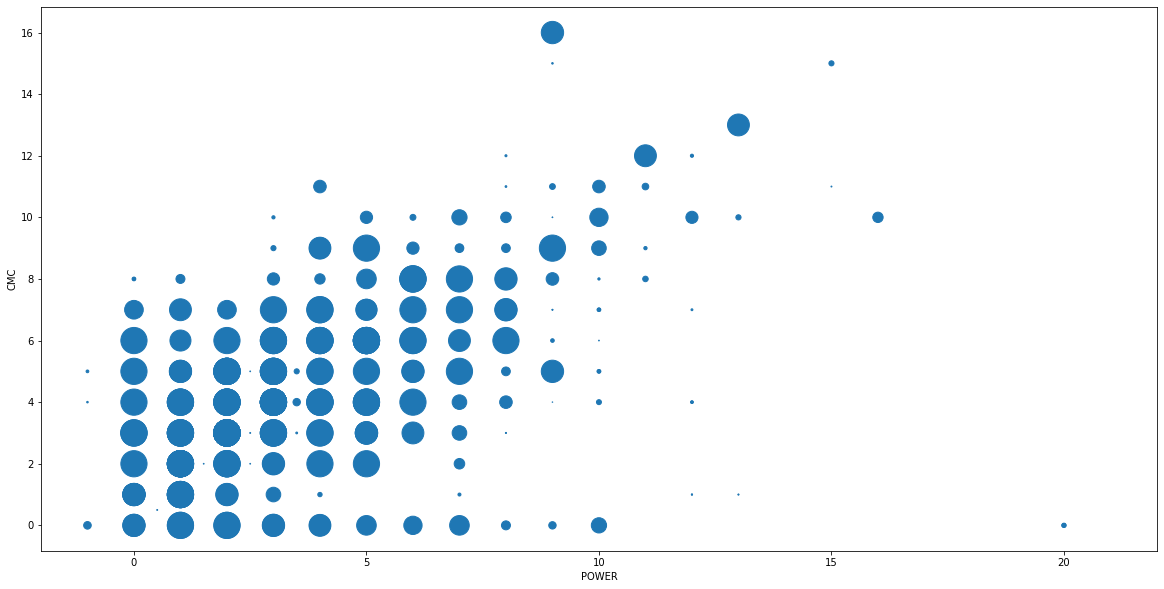

In [13]:
power.plot.scatter('POWER','CMC', figsize = (20,10), xlim = (-2,22), s=power.groupby(['POWER', 'CMC']).size()*.3)

# conclusion
Here is my plot of all creatures in mtg right now, cmc value vs power. Note the obvious outlier here is a 99/99 creature for 15cmc from an unglued set.

this stuff is probably not needed because I can just use the numpy Object data type for my color comparisons. They can be deleted.

In [14]:
power.COLOR = power.COLOR.astype(str)

In [15]:
power.dtypes

POWER    float64
CMC      float64
COLOR     object
dtype: object

## colors
I can break the cards down into colors with this. It took a couple minutes to figure out how to display the single quote bracketed thing as a string but there it is.

make my power changes to the whole original df

In [16]:
non_num_df = df.POWER.str.contains('[^0-9.-]', na=True)
df = df.loc[~non_num_df]
df.POWER = df.POWER.apply(pd.to_numeric)

In [17]:
black = df[df.COLOR == "['B']"]

In [18]:
green = df[df.COLOR == "['G']"]
red = df[df.COLOR == "['R']"]
blue = df[df.COLOR == "['U']"]
white = df[df.COLOR == "['W']"]

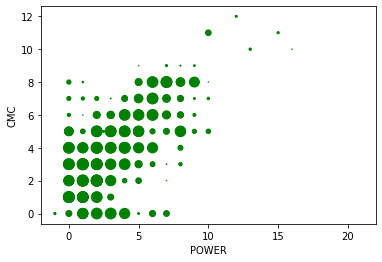

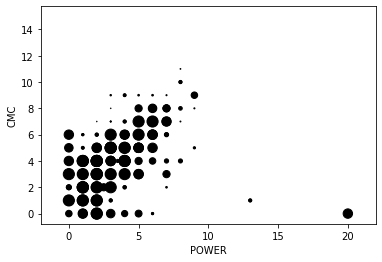

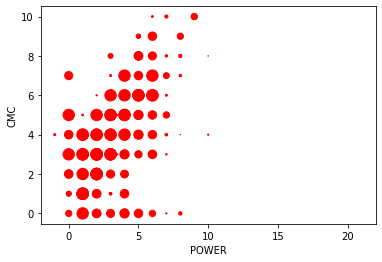

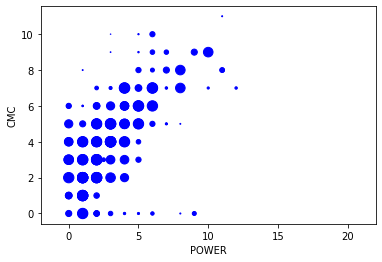

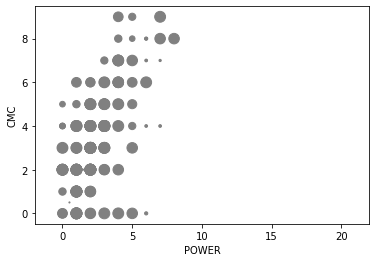

In [33]:
green.plot.scatter('POWER','CMC',xlim = (-2,22),color='g',s=green.groupby(['POWER', 'CMC']).size()*.3)
black.plot.scatter('POWER','CMC',xlim = (-2,22),color='black',s=black.groupby(['POWER', 'CMC']).size()*.3)
red.plot.scatter('POWER','CMC',xlim = (-2,22),color='red',s=red.groupby(['POWER', 'CMC']).size()*.3)
blue.plot.scatter('POWER','CMC',xlim = (-2,22),color='blue',s=blue.groupby(['POWER', 'CMC']).size()*.3)
white.plot.scatter('POWER','CMC',xlim = (-2,22),color='grey',s=white.groupby(['POWER', 'CMC']).size()*.3)

# next steps:
group by both power and cmc, and get the counts. set the count to the diameter of the circle dot.

In [20]:
df.groupby(['POWER', 'CMC']).size()

POWER  CMC 
-1.0   0.0       1
       4.0       1
       5.0       1
 0.0   0.0      86
       1.0     193
              ... 
 15.0  11.0      1
       15.0      7
 16.0  10.0      1
 20.0  0.0       4
 99.0  15.0      1
Length: 137, dtype: int64

# foil ratio scatter plot

In [21]:
df = pd.read_sql_query("select * from prices",conn)

In [22]:
df.head()

,ID,DATETIME,NORMPRICE,FOILPRICE,FOILRATIO
0,2ae1bb79-a931-4d2e-9cc9-a06862dc5cde,2019-07-24 10:15:01,38.88,NaN,NaN
1,4889a668-0f01-4447-ad2e-91b329258f22,2019-07-24 10:15:01,41.96,NaN,NaN
2,5b13ba5a-f4b0-420a-9e4f-a65e57721fa4,2019-07-24 10:15:01,41.99,NaN,NaN
3,37bc0128-a8d0-477c-abcf-2bdc9e38b872,2019-07-24 10:15:01,39.25,NaN,NaN
4,2c23b39b-a4d6-4f10-8ced-fa4b1ed2cf74,2019-07-24 10:15:01,84.99,NaN,NaN


In [23]:
df.dtypes

ID            object
DATETIME      object
NORMPRICE    float64
FOILPRICE    float64
FOILRATIO    float64
dtype: object

In [24]:
len(df)

10891296

In [25]:
#df = df.dropna(subset=['FOILRATIO'],how='all')
df.head()

,ID,DATETIME,NORMPRICE,FOILPRICE,FOILRATIO
0,2ae1bb79-a931-4d2e-9cc9-a06862dc5cde,2019-07-24 10:15:01,38.88,NaN,NaN
1,4889a668-0f01-4447-ad2e-91b329258f22,2019-07-24 10:15:01,41.96,NaN,NaN
2,5b13ba5a-f4b0-420a-9e4f-a65e57721fa4,2019-07-24 10:15:01,41.99,NaN,NaN
3,37bc0128-a8d0-477c-abcf-2bdc9e38b872,2019-07-24 10:15:01,39.25,NaN,NaN
4,2c23b39b-a4d6-4f10-8ced-fa4b1ed2cf74,2019-07-24 10:15:01,84.99,NaN,NaN


In [26]:
len(df)

10891296

In [27]:
df = df[df.ID == 'df70f155-2336-421c-8a9d-69772d2b51a8' ]

In [28]:
df.head()

,ID,DATETIME,NORMPRICE,FOILPRICE,FOILRATIO
760,df70f155-2336-421c-8a9d-69772d2b51a8,2019-07-24 10:15:08,5.10,19.10,3.745098
44273,df70f155-2336-421c-8a9d-69772d2b51a8,2019-05-31 19:48:01,11.18,24.55,2.195886
87775,df70f155-2336-421c-8a9d-69772d2b51a8,2019-06-11 16:34:11,9.88,23.57,2.385628
131281,df70f155-2336-421c-8a9d-69772d2b51a8,2019-06-17 08:55:28,9.76,21.63,2.216189
174789,df70f155-2336-421c-8a9d-69772d2b51a8,2019-06-17 14:24:20,9.76,21.63,2.216189


In [29]:

try:
    df.plot.scatter('NORMPRICE','DATETIME')
except:
    print('something went wrong with the price data')
    
    

something went wrong with the price data


In [30]:
df.DATETIME = df['DATETIME'].astype('datetime64[ns]')

In [31]:
df.dtypes

ID                   object
DATETIME     datetime64[ns]
NORMPRICE           float64
FOILPRICE           float64
FOILRATIO           float64
dtype: object

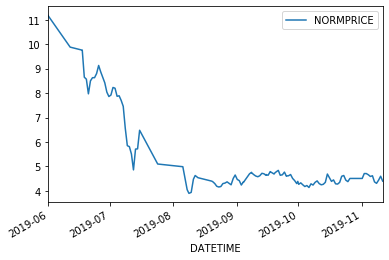

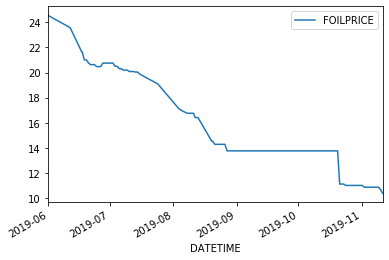

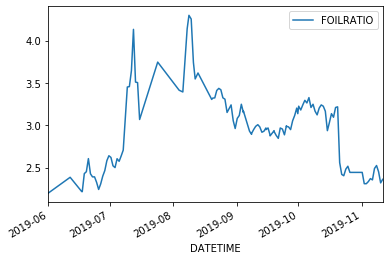

In [32]:
df.plot(y='NORMPRICE',x='DATETIME')
df.plot(y='FOILPRICE',x='DATETIME')
df.plot(y='FOILRATIO',x='DATETIME')

